# NYC taxis tips 

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Setup de pandas pour la visualisation de dataframes
pd.set_option('display.max_columns', None)

In [3]:
#Import des datasets
train = pd.read_parquet("C:\Datasets\\taxis\\train.parquet")
test = pd.read_parquet("C:\Datasets\\taxis\\test.parquet")

In [4]:
#On garde en copie les datasets originelles en memoire au cas ou on a besoin plus tard
train_original = train.copy()
test_original = test.copy()

## Exploration des donnees

### Presentation de features

In [5]:
#Du blabla?
train.head()
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
row_ID,,,,,,,,,,,,,,,,,,,
0,2,2024-01-24 08:02:47,2024-01-24 08:04:45,1.0,0.36,1.0,N,1,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,-73.976495,40.747746,-73.978492
1,2,2024-01-26 14:34:58,2024-01-26 14:42:51,1.0,1.78,1.0,N,1,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.790011,-73.945750
2,2,2024-01-24 15:47:27,2024-01-24 15:51:48,2.0,0.43,1.0,N,2,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,-73.973049,40.797962,-73.968168
3,2,2024-01-04 14:40:17,2024-01-04 14:44:21,1.0,0.61,1.0,N,1,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,-73.978632,40.791705,-73.973049
4,2,2024-01-16 05:54:03,2024-01-16 05:55:59,1.0,0.71,1.0,N,2,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,-73.999918,40.748427,-73.999918


### Nettoyage et preparation des données

On commence d'abord par un nettoyage rutinaire des données, visant se débarraserd es valeurs NaN. On remarque qu'il n'y a pas de données manquantes.

In [6]:
# NaNs per colonne
missing_values = train.isnull().sum()

# Colonnes avec des NaN
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


Avant de procéder à une étude univariée et bivariée, nous devons transformer certaines variables en formats numériques. Pour l'instant, nous effectuerons des transformations de base pour procéder à une étude, et dans une section ultérieure, nous effectuerons des transformations plus avancées des variables.

In [7]:
# Nous créons une unique variable à partir des variables avec format datetype
train['trip_duration'] = (train['tpep_dropoff_datetime'] - train['tpep_pickup_datetime']).dt.total_seconds() / 60 
test['trip_duration'] = (test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']).dt.total_seconds() / 60 

# Encoding des variables categorielles: d'abord on teste des encodings basiques
# Store_and_fwd_flag: dummy
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
# VendorID, RateCodeID et Payment_type: one-hot
categorical_features = ['VendorID', 'RateCodeID', 'Payment_type']

train = pd.get_dummies(train, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int) # On ajoute dtype int à la fin pour assurer un format non-booléen afin de garantir la compatibilité avec scikit learn
test = pd.get_dummies(test, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int)

train, test = train.align(test, join='left', axis=1, fill_value=0) # Certaines catégories n'apparaissent que dans le train set, il faut donc adapter l'encoding dans le test set. 
test = test.drop(columns=['tip_amount'])

In [8]:
test.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration,VendorID_1,VendorID_2,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_99.0,payment_type_1,payment_type_2,payment_type_3,payment_type_4
row_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2024-01-24 08:02:47,2024-01-24 08:04:45,1.0,0.36,0,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,-73.976495,40.747746,-73.978492,1.966667,0,1,1,0,0,0,0,0,1,0,0,0
1,2024-01-26 14:34:58,2024-01-26 14:42:51,1.0,1.78,0,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.790011,-73.945750,7.883333,0,1,1,0,0,0,0,0,1,0,0,0
2,2024-01-24 15:47:27,2024-01-24 15:51:48,2.0,0.43,0,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,-73.973049,40.797962,-73.968168,4.350000,0,1,1,0,0,0,0,0,0,1,0,0
3,2024-01-04 14:40:17,2024-01-04 14:44:21,1.0,0.61,0,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,-73.978632,40.791705,-73.973049,4.066667,0,1,1,0,0,0,0,0,1,0,0,0
4,2024-01-16 05:54:03,2024-01-16 05:55:59,1.0,0.71,0,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,-73.999918,40.748427,-73.999918,1.933333,0,1,1,0,0,0,0,0,0,1,0,0


### Etude univariee et bivariee 

In [9]:
numerical_vars = train.select_dtypes(include=['float64', 'int64']).columns

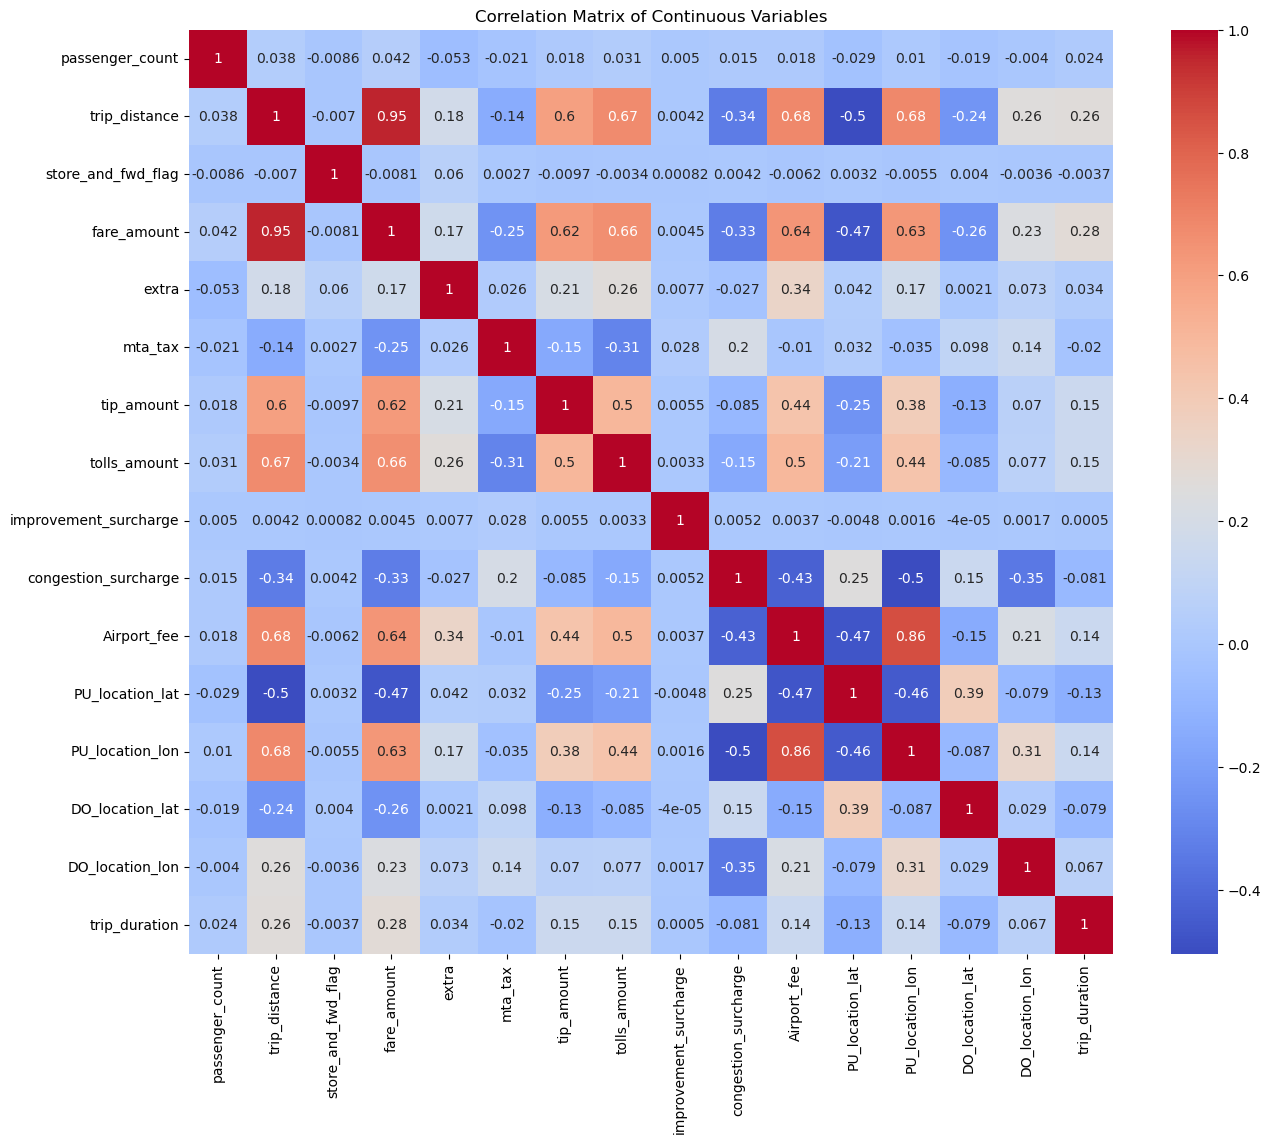

In [10]:
# Plotting the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(train[numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

## Model fitting

In [11]:
## Model fitting
train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])
test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])

X_train = train.drop(columns=['tip_amount'])
y_train = train['tip_amount']

X_test = test

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
# Get today's date in the format YYYYMMDD
today_date = datetime.now().strftime("%Y_%m_%d")

# Create the submission DataFrame
submission = pd.DataFrame({
    'row_ID': test.index,  # Use 'row_ID' column or index from the test set
    'tip_amount': y_pred
})

# Save the submission in Parquet format with today's date in the filename
filename = f'kaggle_submission_{today_date}.parquet'
submission.to_parquet(filename, index=False)

print(f"Predictions saved to '{filename}'")


Predictions saved to 'kaggle_submission_2024_11_05.parquet'
